In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from requests import get

Going with some basics via a Medium article from Riley Predum found here: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981
<br/>
<br/>
Criteria:
- Has image
- Within 1 mile from 11377 (Woodside)

In [3]:
response = get('https://newyork.craigslist.org/search/apa?hasPic=1&search_distance=1&postal=11377&availabilityMode=0&sale_date=all+dates')

In [5]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [23]:
post_one = posts[0]
post_one_price = post_one.a.text
post_one_price.strip()

'$1,700'

In [11]:
#grab the time and datetime it was posted
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']
post_one_datetime

'2020-07-31 08:57'

In [12]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
post_one_title_text

'NO FEE Woodside  1bedroom apt'

In [21]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

# post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

post_one_hood = posts[0].find('span', class_='result-hood').text #grabs the neighborhood, this is the problem column that requires
#a lot of cleaning and figuring out later.

In [22]:
post_one_hood

' (Woodside)'

## From here we iterate

In [24]:
from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

In [28]:
# find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    response = get('https://newyork.craigslist.org/search/apa?'
                  + 's='
                  + str(page)
                  + '&availabilityMode=0'
                  + '&hasPic=1'
                  + '&postal=11377'
                  + '&search_distance=1')
    sleep(randint(1,5))
    
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(reqeusts, response.status_code))
    
    page_html = BeautifulSoup(response.text, 'html.parser')
    posts = html_soup.find_all('li', class_= 'result-row')
    
    #extract data item-wise
    for post in posts:
        if post.find('span', class_='result-hood') is not None:
            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "").replace(",", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!


Scrape complete!


In [29]:

import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           370 non-null    object 
 1   neighborhood     370 non-null    object 
 2   post title       370 non-null    object 
 3   number bedrooms  290 non-null    object 
 4   sqft             40 non-null     float64
 5   URL              370 non-null    object 
 6   price            370 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 20.4+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2020-07-31 08:57,(Woodside),NO FEE Woodside 1bedroom apt,1,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1700
1,2020-08-03 16:06,(43rd Ave & 53rd Street),"53RD STREET OFF 43RD AVE, 1 BEDROOM NEAR 7 TRAIN",1,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1700
2,2020-08-03 16:37,(Skillman Ave & 51st Street),SKILLMAN AVE & 51ST STREET ONE BEDROOM NEAR 7...,1,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1700
3,2020-08-06 11:03,(Sunnyside),$2100 Sunnyside 2 Bedroom - Available August 1st,2,NaN,https://newyork.craigslist.org/que/apa/d/woods...,2100
4,2020-08-06 15:47,(Woodside),"$1619 1br - Junior One Bedroom in Woodside, Qu...",NaN,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1
5,2020-08-07 16:07,(43rd Ave & 53rd Street),"53RD STREET OFF 43RD AVE, 1 BEDROOM NEAR 7 TRAIN",1,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1650
6,2020-08-07 17:24,(Woodside),BEAUTIFUL AND SPACIOUS 2/BEDROOM APARTMENT !! ...,NaN,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1600
7,2020-08-10 13:54,(Sunnyside / Woodside / LIC),Large studio - View of Sunnyside Gardens,NaN,450.0,https://newyork.craigslist.org/que/apa/d/woods...,1750
8,2020-08-12 10:35,(Sunnyside),$2100 Sunnyside 2 Bedroom - Available August 1st,2,NaN,https://newyork.craigslist.org/que/apa/d/woods...,2100
9,2020-08-13 13:09,(woodside),REDUCED! * Absentee Landlord * Heat Included *,1,NaN,https://newyork.craigslist.org/que/apa/d/woods...,1500


In [30]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many unique posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['number bedrooms'] = eb_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
eb_apts['neighborhood'] = eb_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
eb_apts['neighborhood'] = eb_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
# eb_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
# eb_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data
eb_apts.to_csv("eb_apts_1642_Jan_2_19_clean.csv", index=False)

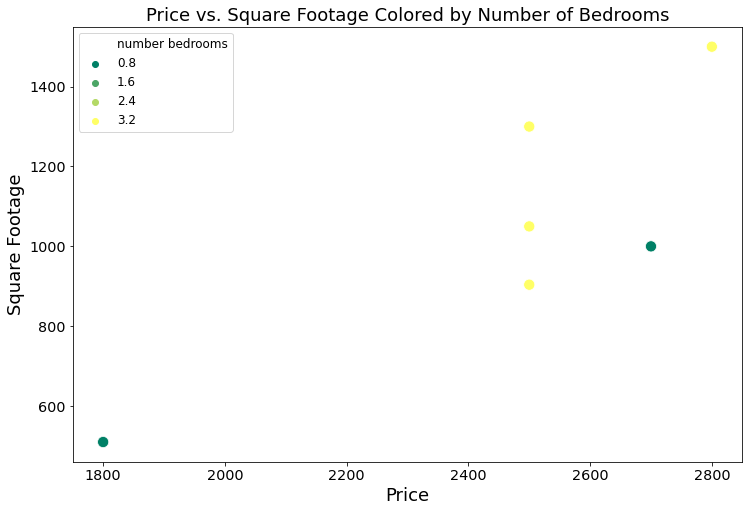

In [35]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

There aren't that many apartments listed with square footage in Woodside. I notice this is a trend across several of the NYC burroughs

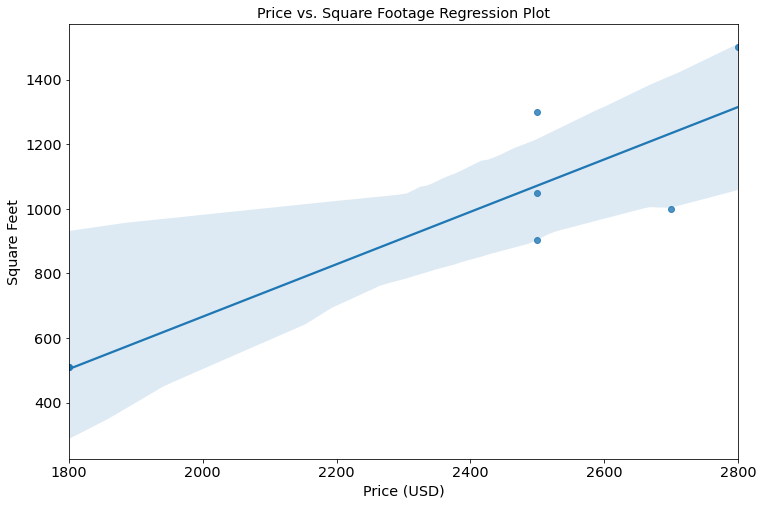

In [36]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

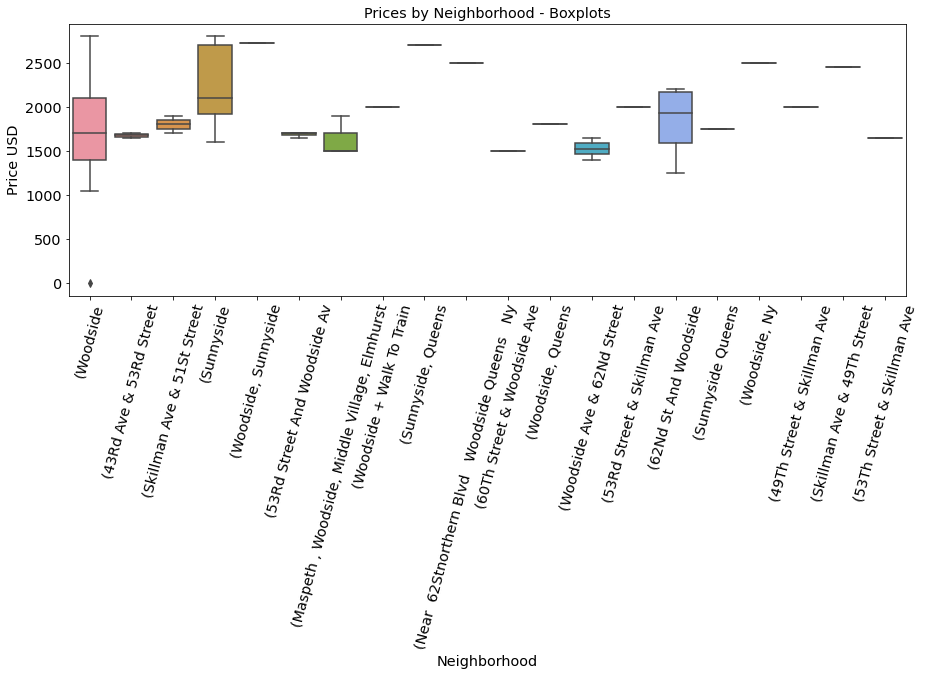

In [37]:
sns.boxplot(x='neighborhood', y='price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

There's a big difference with how people regularize their neighborhood categorizations.

We can filter them out as we expand past just Woodside with a min count

## For future
<br/>
- Forest Hills (11375) is fairly center
- filter out neighborhoods a bit before boxplot
- check sparsity of SQFT data
- pull longitude / latitude data for using Leaflet plot